In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


Mean Squared Error (log scale): 0.3876
R-squared: 0.4269


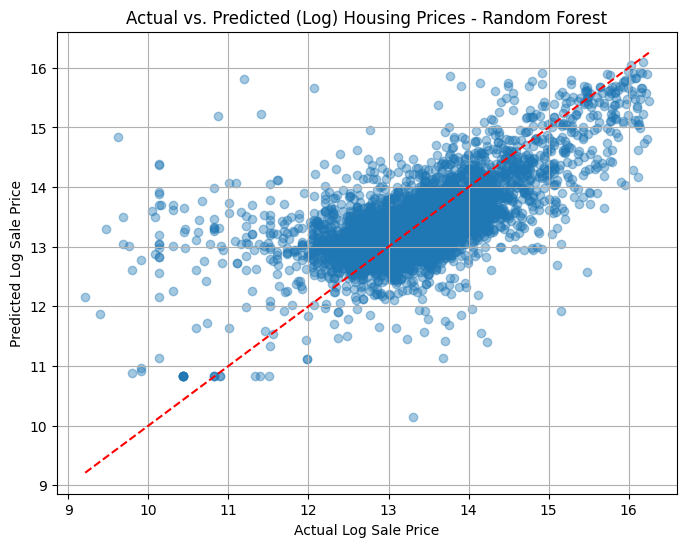

In [2]:

# Load dataset
url = 'https://raw.githubusercontent.com/karimitani/Real-Estate/refs/heads/master/nyc-rolling-sales.csv'
df = pd.read_csv(url)

# Map borough codes
borough_map = {
    1: "Manhattan",
    2: "Bronx",
    3: "Brooklyn",
    4: "Queens",
    5: "Staten Island"
}
df['BOROUGH_NAME'] = df['BOROUGH'].map(borough_map)

# Convert sale price to numeric and drop invalid entries
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['YEAR BUILT'] = pd.to_numeric(df['YEAR BUILT'], errors='coerce')
df = df.dropna(subset=['SALE PRICE', 'GROSS SQUARE FEET', 'LAND SQUARE FEET', 'YEAR BUILT'])

# Remove outliers and zeroes
df = df[
    (df['SALE PRICE'] > 10000) &
    (df['SALE PRICE'] < df['SALE PRICE'].quantile(0.99)) &
    (df['GROSS SQUARE FEET'] > 100) &
    (df['LAND SQUARE FEET'] > 100)
]

# Log transformation
df['LOG_SALE_PRICE'] = np.log(df['SALE PRICE'])
df['LOG_GROSS_SQFT'] = np.log(df['GROSS SQUARE FEET'])
df['LOG_LAND_SQFT'] = np.log(df['LAND SQUARE FEET'])

# Feature selection
features = ['LOG_GROSS_SQFT', 'LOG_LAND_SQFT', 'YEAR BUILT', 'BOROUGH_NAME', 'BUILDING CLASS CATEGORY']
df = df[features + ['LOG_SALE_PRICE']].dropna()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['BOROUGH_NAME', 'BUILDING CLASS CATEGORY'], drop_first=True)

# Define X and y
X = df_encoded.drop('LOG_SALE_PRICE', axis=1)
y = df_encoded['LOG_SALE_PRICE']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (log scale): {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Log Sale Price")
plt.ylabel("Predicted Log Sale Price")
plt.title("Actual vs. Predicted (Log) Housing Prices - Random Forest")
plt.grid(True)
plt.show()


###  **Model Evaluation**
- **Mean Squared Error (log scale)**: **0.3876** (previously 3.7084)
- **R-squared**: **0.4269** (up from 0.0120)

This means your **Random Forest model now explains ~43% of the variance** in log sale prices—a substantial improvement over the linear regression model.

---

###  **Plot Analysis**
- The scatter points now follow the red dashed line (ideal prediction) much more closely.
- There is still some underestimation in higher actual values (right side), which is typical due to how ensemble models average predictions.


Great question!

###  What Does "Log" Mean in This Context?

In your housing model, **"log"** refers to the **natural logarithm (ln)** transformation applied to variables like:

- `SALE PRICE` → `LOG_SALE_PRICE`
- `GROSS SQUARE FEET` → `LOG_GROSS_SQFT`

This is done using `np.log()`, which applies the natural logarithm (base *e*, where *e* ≈ 2.718).

---

### Why Use Log Transformations?

1. **Reduce Skewness**: Housing prices are often right-skewed (a few properties are extremely expensive). Taking the log makes the distribution more symmetric and bell-shaped, which improves model performance.
2. **Stabilize Variance**: Models work better when the variance of the outcome variable is consistent across its range. Logs help achieve that.
3. **Interpretability**:
   - In regression, a coefficient on a log-transformed variable shows **percentage change** instead of absolute change.
   - Example:  
     If `log(SALE PRICE)` increases by 0.1 → actual price increases by ~10.5%  
     (because `e^0.1 ≈ 1.105`)

---

###  Example:
| SALE PRICE | LOG_SALE_PRICE |
|------------|----------------|
| 100,000    | 11.51          |
| 500,000    | 13.12          |
| 1,000,000  | 13.82          |

Log scale compresses large values, making the data easier to model.


In [5]:
# Export predictions
results = pd.DataFrame({
    'Actual_Log_Sale_Price': y_test,
    'Predicted_Log_Sale_Price': y_pred
})

# results.to_csv("predicted_vs_actual_prices.csv", index=False)
# print("Results exported to predicted_vs_actual_prices.csv")

results


,Actual_Log_Sale_Price,Predicted_Log_Sale_Price
18525,12.736701,12.925525
44105,13.304685,13.236403
29217,12.478006,13.519906
24501,12.983101,12.587626
44272,13.715690,14.002103
...,...,...
79991,12.465355,12.333100
42215,13.741164,13.643883
36646,13.384728,13.992533
78283,12.676076,12.454139


## `Why the performance was poor:`

Mean Squared Error (log scale): 3.7084
R-squared: 0.0120


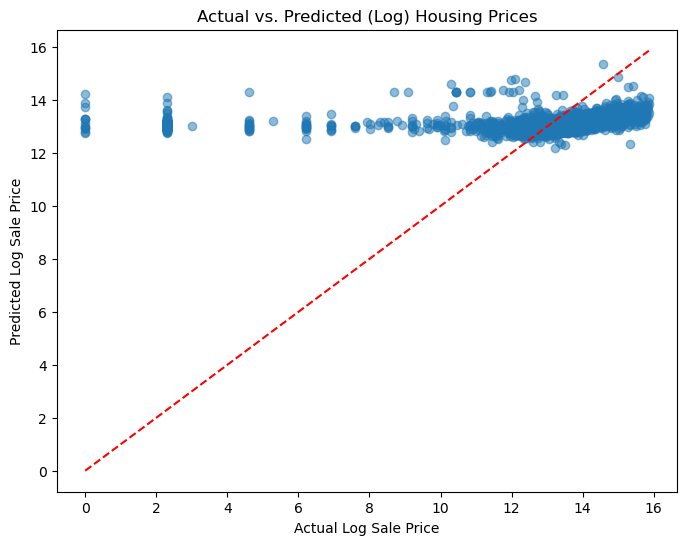

In [44]:
# Ensure 'SALE PRICE' is numeric (coerce errors to NaN)
housing_data['SALE PRICE'] = pd.to_numeric(housing_data['SALE PRICE'], errors='coerce')

# Drop rows with missing values after coercion
housing_data = housing_data.dropna()

# Remove outliers based on the 'SALE PRICE' quantile
housing_data = housing_data[
    (housing_data['SALE PRICE'] < housing_data['SALE PRICE'].quantile(0.99))
]

# Continue with column selection and transformation
columns_to_use = ['SALE PRICE', 'GROSS SQUARE FEET', 'YEAR BUILT']
housing_data = housing_data[columns_to_use]

# Convert all relevant columns to numeric, coercing errors
housing_data = housing_data.apply(pd.to_numeric, errors='coerce')

# Drop any remaining NaN values
housing_data = housing_data.dropna()

# Filter out zero or negative values before log transformation
housing_data = housing_data[(
    housing_data['SALE PRICE'] > 0) & (housing_data['GROSS SQUARE FEET'] > 0)
]

# Log-transform relevant columns
housing_data['LOG_SALE_PRICE'] = np.log(housing_data['SALE PRICE'])
housing_data['LOG_GROSS_SQFT'] = np.log(housing_data['GROSS SQUARE FEET'])

# Define features and target
X = housing_data[['LOG_GROSS_SQFT', 'YEAR BUILT']]
y = housing_data['LOG_SALE_PRICE']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (log scale): {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Visualization
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Log Sale Price")
plt.ylabel("Predicted Log Sale Price")
plt.title("Actual vs. Predicted (Log) Housing Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


**why the performance was poor**:

---

##  **Summary of Linear Regression Code and Results**

```python
# Features used
X = housing_data[['LOG_GROSS_SQFT', 'YEAR BUILT']]
y = housing_data['LOG_SALE_PRICE']
```

**Model Type**: Linear Regression  
**R-squared**: `0.0120`  
**Mean Squared Error (log scale)**: `3.7084`

---

##  Why the Results Were Poor

| Reason | Explanation |
|--------|-------------|
| **1. Limited Features** | Only two features were used: `LOG_GROSS_SQFT` and `YEAR BUILT`. These are insufficient to capture the full variability of NYC housing prices. |
| **2. No Categorical Variables** | Important categorical variables like `BOROUGH`, `BUILDING CLASS`, or `NEIGHBORHOOD` were excluded. These have a major impact on property value. |
| **3. Assumes Linearity** | Linear regression assumes a linear relationship. Housing prices often follow more complex, nonlinear patterns. |
| **4. Outliers Still Present** | Even after dropping the top 1% of `SALE PRICE`, NYC real estate can have subtle outliers (e.g., large co-ops, new developments) that skew results. |
| **5. Log Scale Issues** | Some predicted values clustered around a narrow range (~12.5–14) while actual values were spread out. The model couldn't capture extreme highs/lows. |

---

##  Visual Interpretation (from your plot)

- **Most points are below the red line** → Underprediction.
- **Flat distribution of predictions** → Model fails to adjust predictions across price ranges.
- **Very few predictions match actuals well** → Poor model fit.





```python
random_state=42
```
is used to **ensure reproducibility**.
---

###  What It Means

- The `train_test_split()` function randomly splits the dataset into training and test sets.
- `random_state=42` **sets the seed** for the random number generator so that **every time you run the code, you get the exact same split**.
- The number `42` is arbitrary — you could use any integer. People often use `42` because of a joke from *The Hitchhiker’s Guide to the Galaxy*, where 42 is the "answer to everything."



In [50]:
print(housing_data.columns)


Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'BOROUGH_NAME'],
      dtype='object')
